In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import plot_tree

import xgboost as xgb

In [4]:
#### HELPER FUNCTIONS ####


def plot_predicted_distribtuions(trained_model):
    ys = [y_train, y_test]
    Xs = [X_train, X_test]
    titles = ['Train Distribution', 'Test Distribution']

    fix, ax = plt.subplots(1, 2, figsize=(12,6))
    for i in range(2):
        counts, bins = np.histogram(ys[i])
        counts_pred, bins_pred = np.histogram(trained_model.predict(Xs[i]))

        ax[i].hist(bins[:-1], bins, weights=counts, label='Actual Distribtuion', color='black')
        ax[i].hist(bins[:-1], bins_pred, weights=counts_pred, label='Predicted Distribtuion', color='red', alpha=0.75)
        ax[i].legend()
        ax[i].set_title(f'{titles[i]}')
    plt.show()


def plot_feature_importances(trained_model, training_set, top_n=15, figsize=(8,10)):
  features = training_set.columns
  importances = trained_model.feature_importances_
  df = pd.DataFrame()
  df['Feature'] = features
  df['Importance'] = importances
  df.sort_values(by='Importance', ascending=False, inplace=True)
  df = df.head(top_n)

  plt.figure(figsize=figsize)
  sns.barplot(data=df, x='Importance', y='Feature', color='blue')
  plt.title(f'Top {top_n} Features')
  plt.show()


def plot_forest(trained_model, training_set, n_trees=100, n_rows=20, n_cols=5, figsize=(100,100), class_name='Yield Per Colony',
                is_gb=False, is_xgb=False, savefig=False, dpi=300):
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  column_names = training_set.columns
  ax = axes.ravel()
  if not is_xgb:
    estimators = trained_model.estimators_.reshape(n_trees,) if is_gb else trained_model.estimators_

  for i in range(n_trees):
    if is_xgb:
      xgb.plot_tree(trained_model, num_trees=i, ax=ax[i])
    else:
      plot_tree(estimators[i],
            feature_names=column_names,
            class_names=class_name,
            filled=True, impurity=True,
            rounded=True, ax=ax[i])
      ax[i].set_title(f'Estimator {i+1}')
  if savefig:
    plt.savefig('trees.png', dpi=dpi)
  plt.show()


def train_test_MSE(trained_model, y_test, X_train):
  y_preds = trained_model.predict(X_test)
  MSE_test = mean_squared_error(y_test, y_preds)
  MSE_train = mean_squared_error(y_train, model.predict(X_train))
  RMSE_test, RMSE_train = np.sqrt(MSE_test), np.sqrt(MSE_train)
  print(f'MSE_test: {MSE_test:.2f}\nMSE_train: {MSE_train:.2f}')
  print(f'RMSE_test: {RMSE_test:.2f}\nRMSE_train: {RMSE_train:.2f}')

In [5]:
df = pd.read_csv('/content/drive/MyDrive/DABP Project/Data/Final Data/final_data_dummies.csv')

In [6]:
# Set train and test set, test is anything beyond 2016
train = df[df['year'] < 2016]
test = df[df['year'] >= 2016]
X_train = train.drop(columns='yieldpercol')
y_train = train['yieldpercol']
X_test = test.drop(columns='yieldpercol')
y_test = test['yieldpercol']

MSE_test: 291.75
MSE_train: 224.53
RMSE_test: 17.08
RMSE_train: 14.98


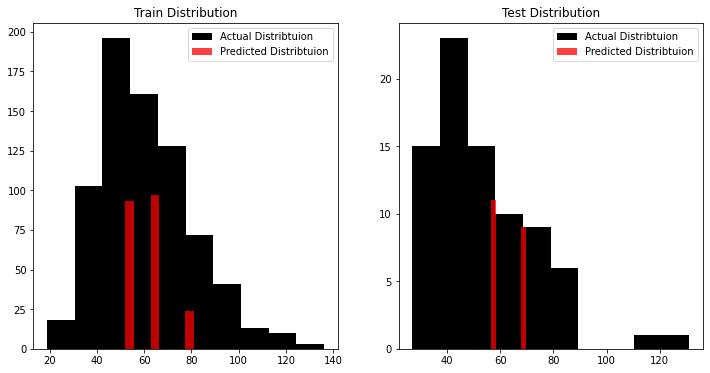

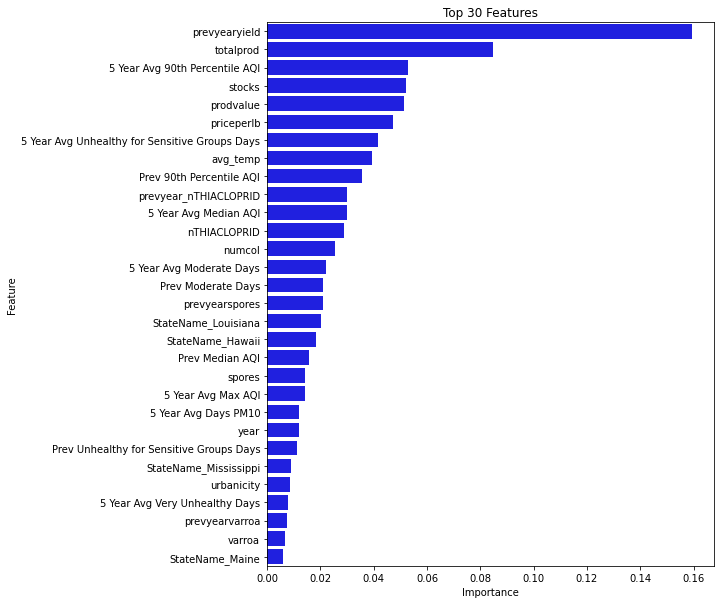

In [7]:
model = RandomForestRegressor(n_estimators=1000, max_features='sqrt', max_depth=2, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=30)

MSE_test: 290.31
MSE_train: 212.45
RMSE_test: 17.04
RMSE_train: 14.58


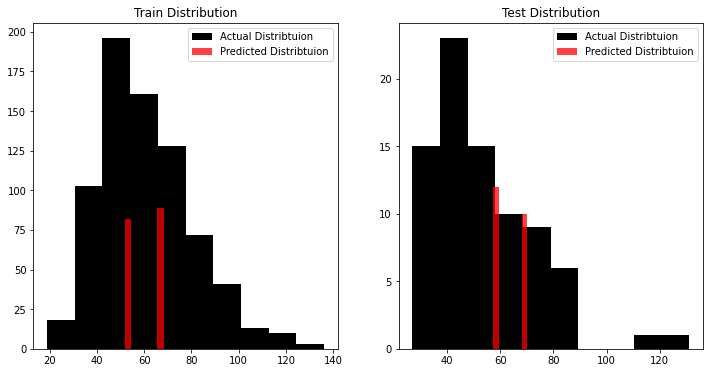

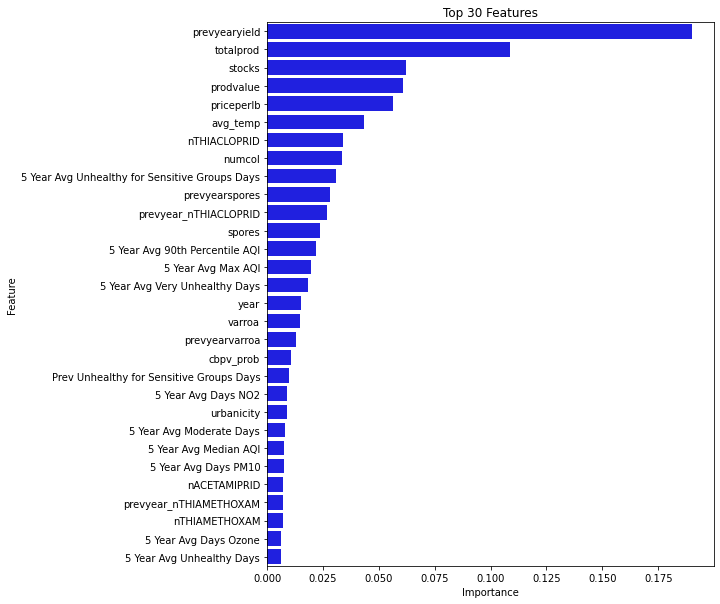

In [8]:
model = RandomForestRegressor(n_estimators=5000, max_features='sqrt', max_depth=3, min_samples_leaf=50, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=30)

MSE_test: 280.48
MSE_train: 222.50
RMSE_test: 16.75
RMSE_train: 14.92


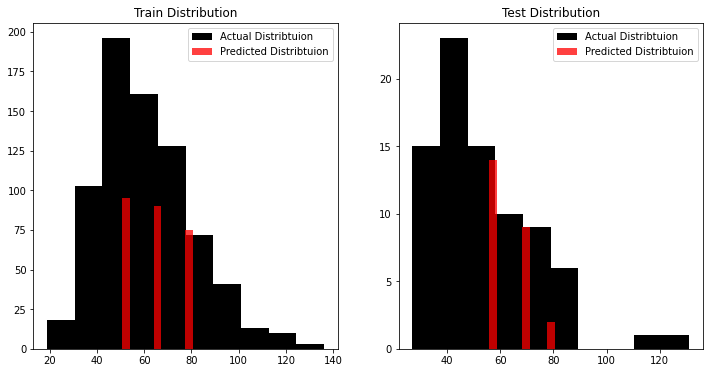

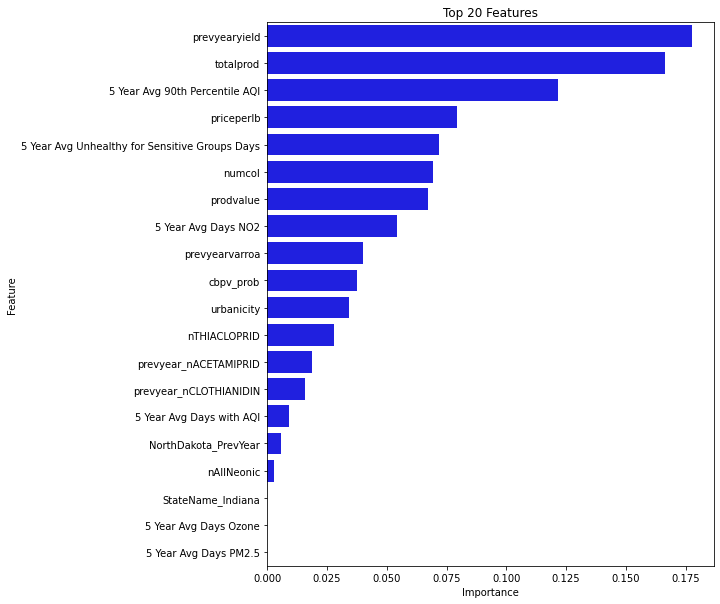

In [9]:
model = RandomForestRegressor(n_estimators=5, max_features='sqrt', 
                              max_depth=3, min_samples_leaf=50, 
                              min_samples_split=25, random_state=123,
                              n_jobs=-1)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=20)

MSE_test: 134.76
MSE_train: 100.38
RMSE_test: 11.61
RMSE_train: 10.02


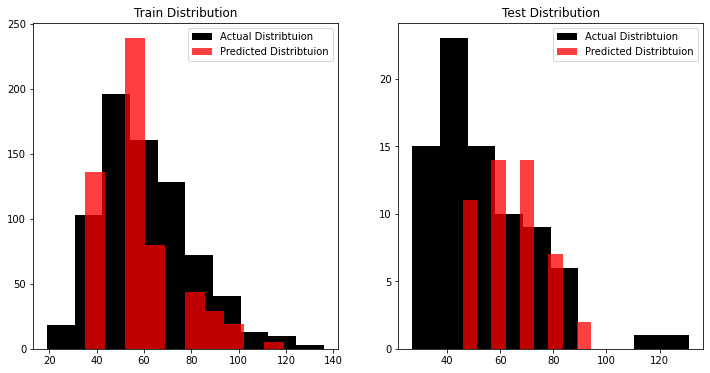

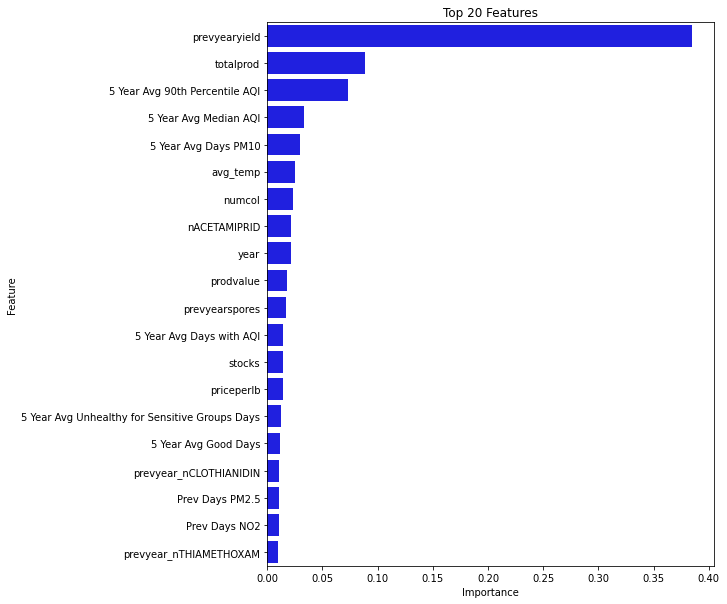

In [10]:
### AdaBoost
model = AdaBoostRegressor(random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=20)

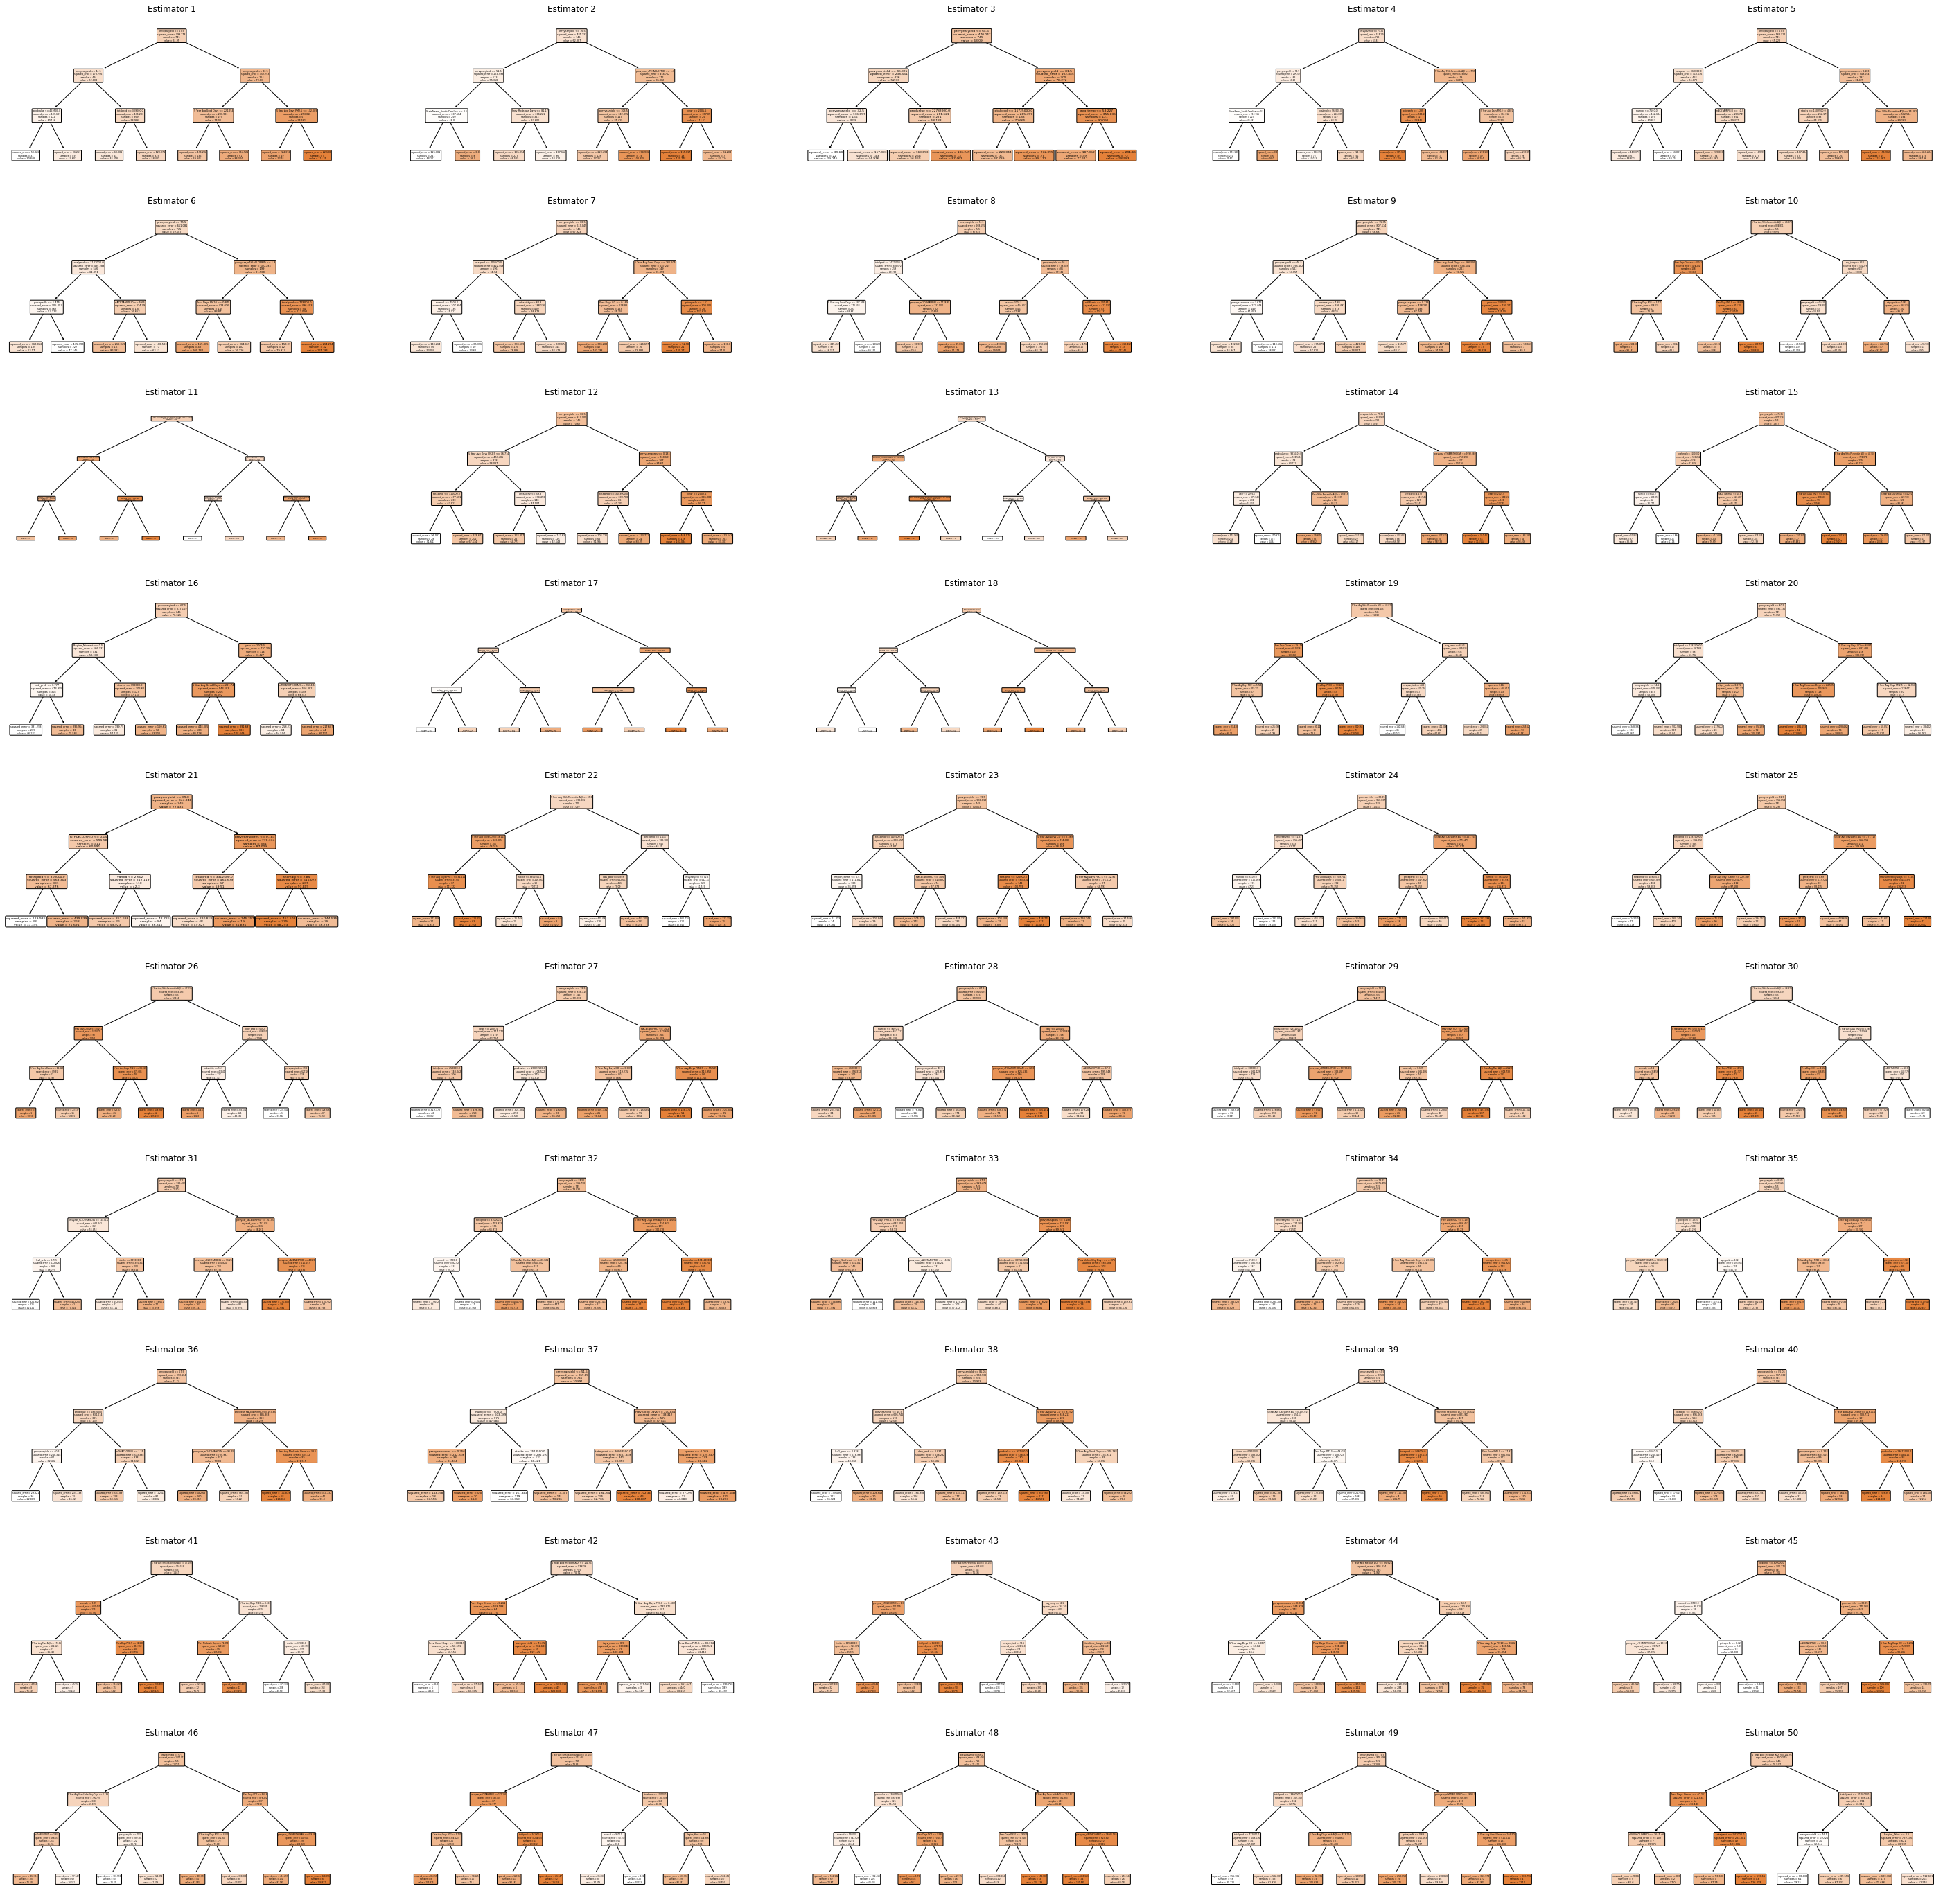

In [11]:
plot_forest(model, X_train, n_trees=50, n_rows=10, n_cols=5, figsize=(50,50))

In [12]:
model.estimator_weights_

array([1.4195918 , 1.092736  , 1.2030939 , 1.0551477 , 0.76893661,
       0.85058728, 0.97528735, 1.02859148, 0.61811858, 1.12689096,
       0.91665297, 0.97117625, 1.0416531 , 0.83678826, 0.98079034,
       0.80110486, 0.72855608, 1.0787928 , 1.04319156, 0.66166613,
       0.96340273, 0.88544931, 0.59604974, 0.84332767, 0.90168572,
       0.76148091, 0.8311055 , 1.23793884, 0.81103657, 1.21385868,
       1.08537269, 0.92031338, 0.82324452, 1.16456614, 1.0028418 ,
       0.81003682, 1.17576255, 0.87002193, 0.71673214, 0.72368059,
       1.20640215, 0.93934588, 0.7136909 , 0.93159111, 0.6833103 ,
       1.19265299, 0.68559686, 1.19662665, 0.89808375, 0.83878869])

MSE_test: 85.06
MSE_train: 33.70
RMSE_test: 9.22
RMSE_train: 5.81


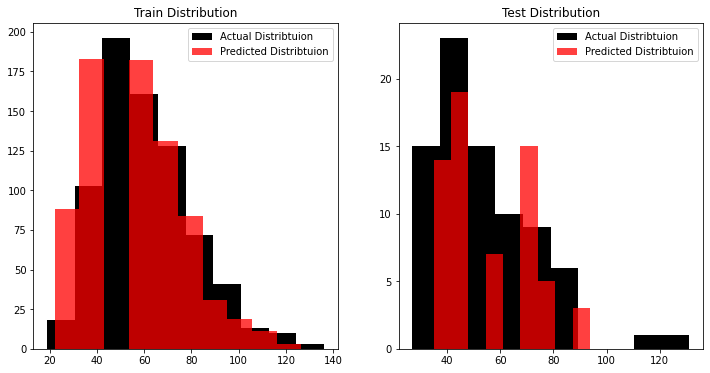

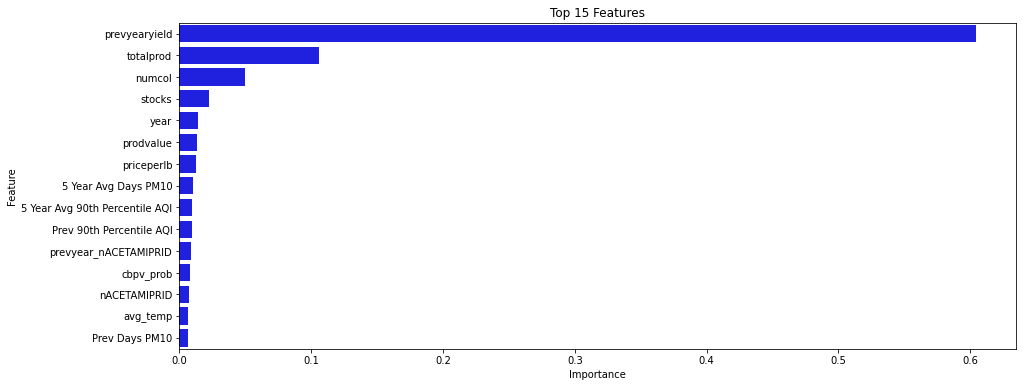

In [13]:
### GradientBoost
model = GradientBoostingRegressor(n_estimators=100, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=15, figsize=(15, 6))

In [14]:
base_estimate = np.mean(y_train)
print(f'Base Estimate = {base_estimate:.2f}')

Base Estimate = 60.93


In [15]:
#### Try GBT again but drop some columns
# Set train and test set, test is anything beyond 2016
df_dropped_cols = df.copy()
df_dropped_cols.columns
df_dropped_cols.rename(columns = lambda x: x.replace(' ', '_'), inplace=True) # Remove whitespace
df_dropped_cols.drop(columns=['totalprod', 'prodvalue', 'stocks', 'priceperlb'], inplace=True)
train = df_dropped_cols[df_dropped_cols['year'] < 2016]
test = df_dropped_cols[df_dropped_cols['year'] >= 2016]
train.drop(columns='year', inplace=True)
test.drop(columns='year', inplace=True)
X_train = train.drop(columns='yieldpercol')
y_train = train['yieldpercol']
X_test = test.drop(columns='yieldpercol')
y_test = test['yieldpercol']



/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


MSE_test: 111.94
MSE_train: 52.66
RMSE_test: 10.58
RMSE_train: 7.26


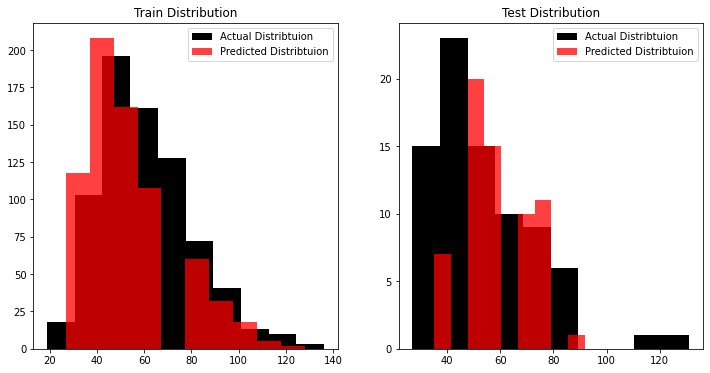

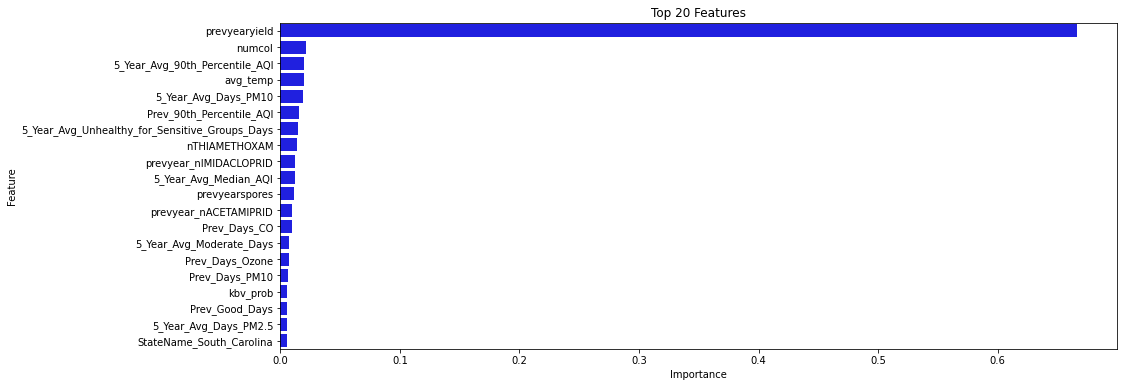

In [16]:
### GradientBoost
model = GradientBoostingRegressor(n_estimators=100, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=20, figsize=(15, 6))

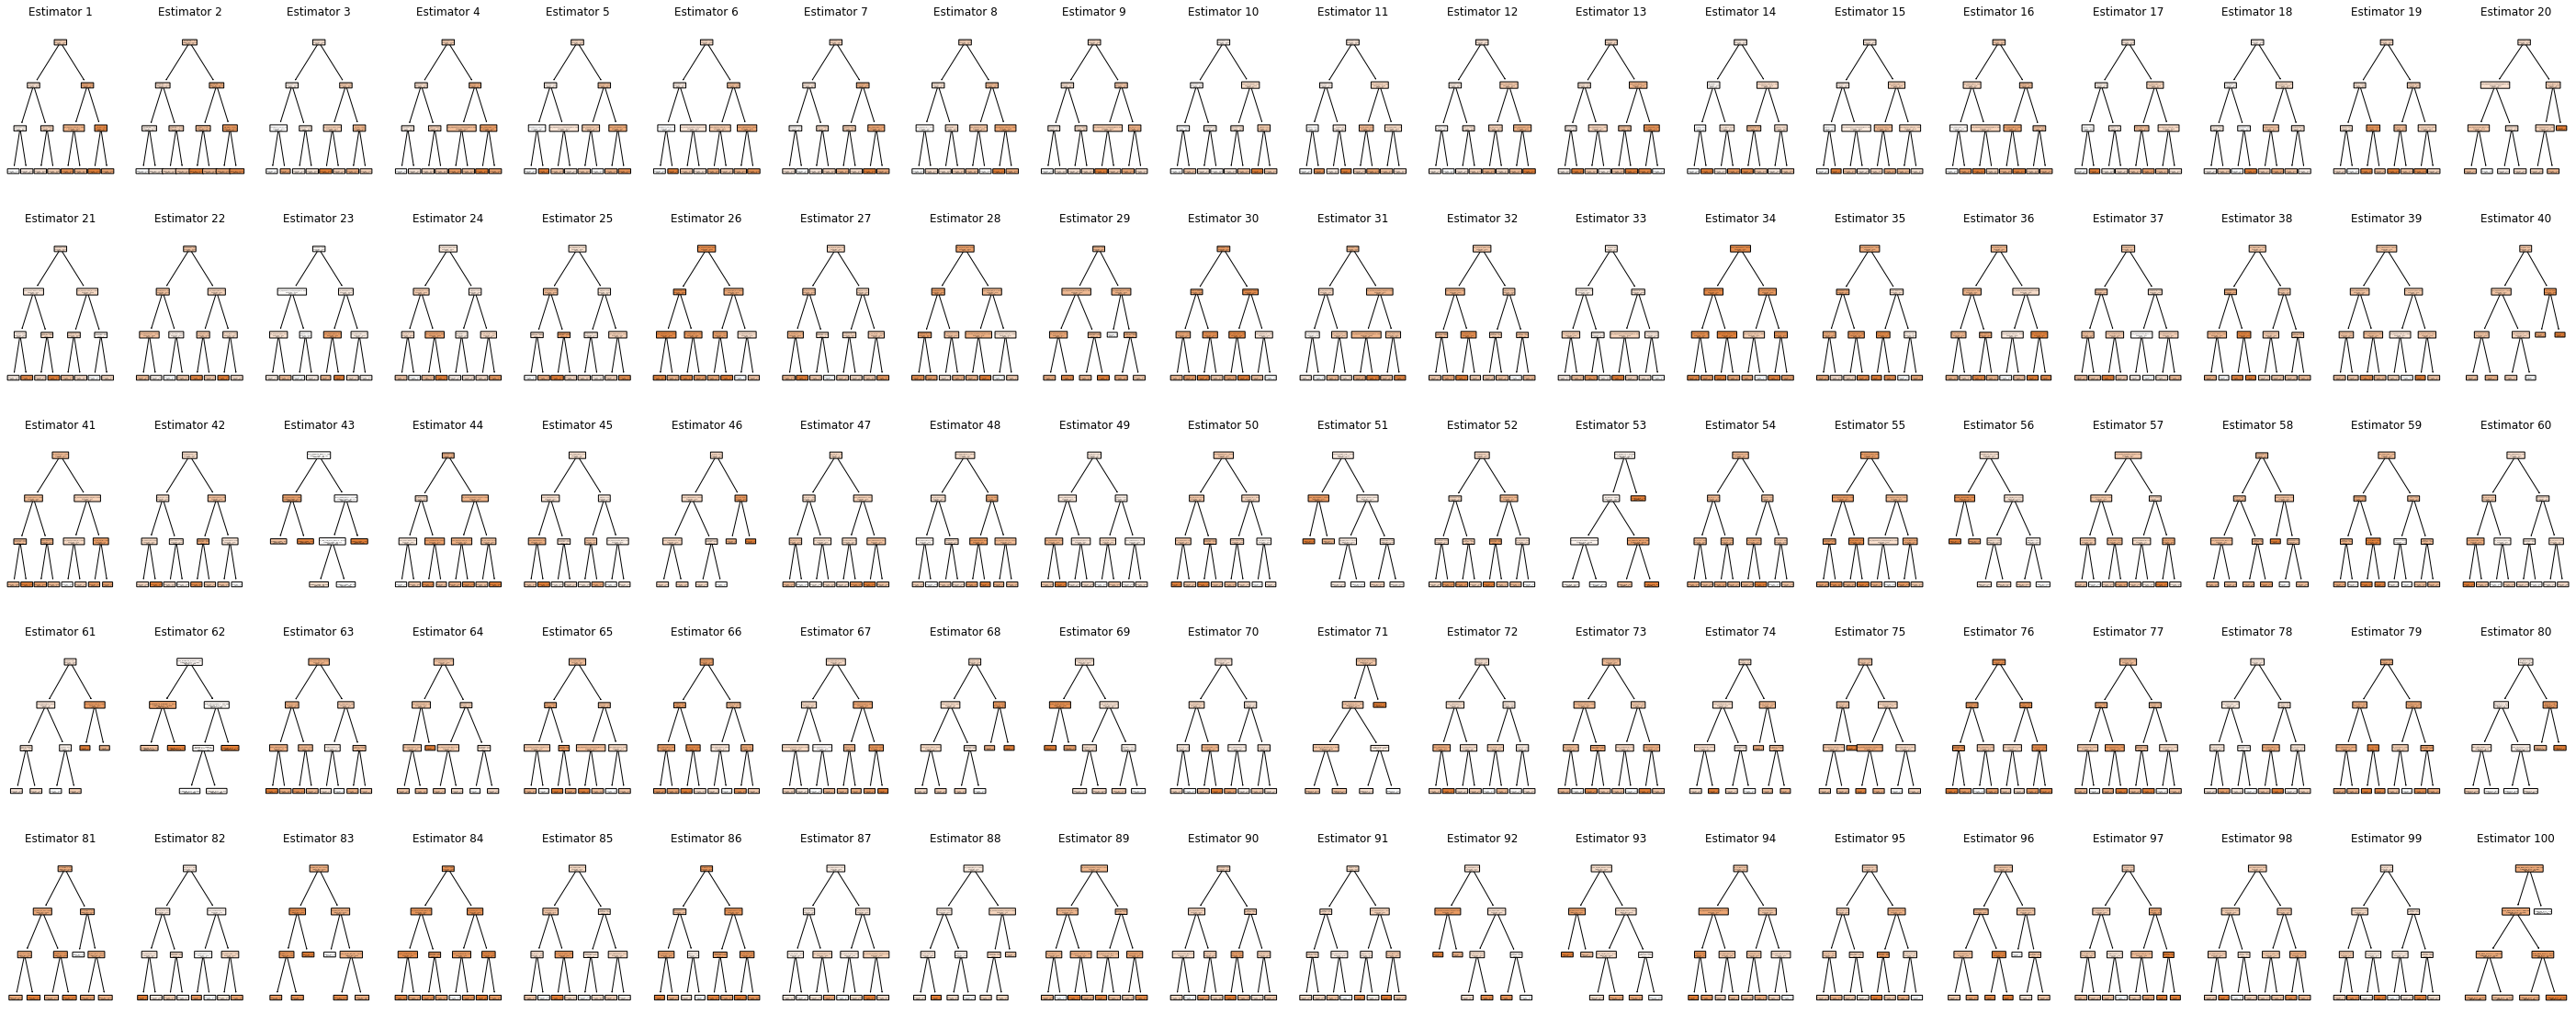

In [17]:
plot_forest(model, X_train, is_gb=True, n_rows=5, n_cols=20, figsize=(50,20))

MSE_test: 106.45
MSE_train: 56.40
RMSE_test: 10.32
RMSE_train: 7.51


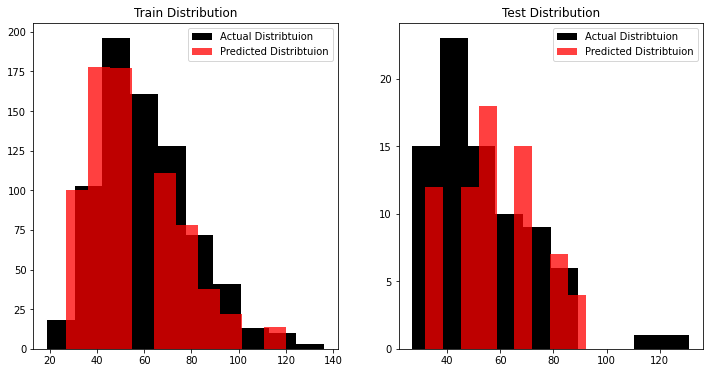

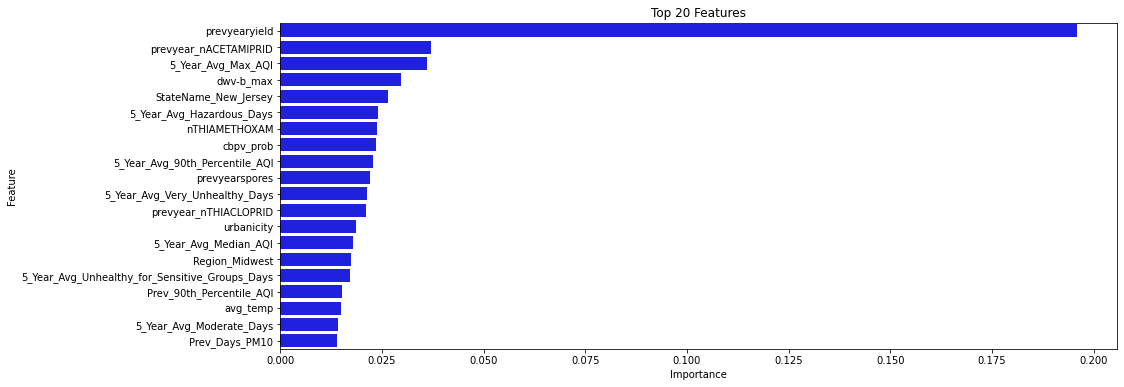

In [18]:
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=20, figsize=(15, 6))

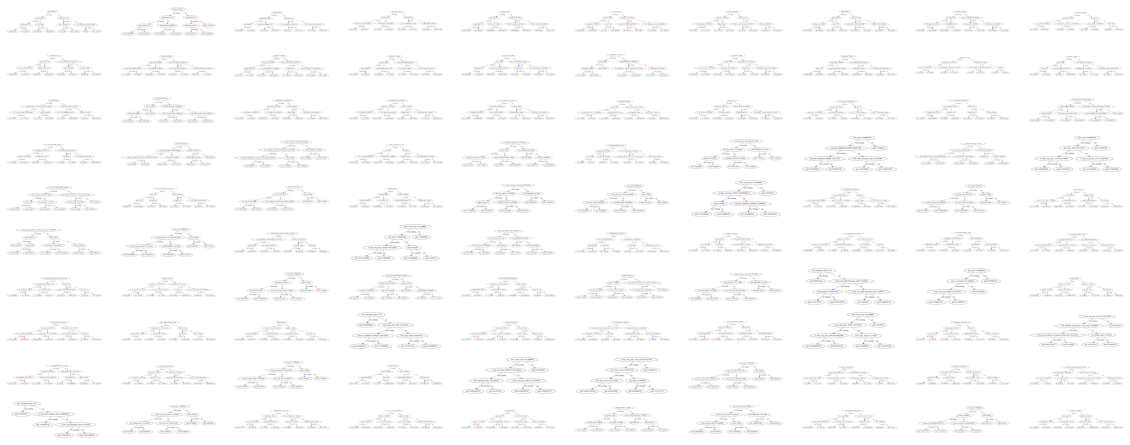

In [19]:
plot_forest(model, X_train, is_xgb=True, n_rows=10, n_cols=10, figsize=(20, 8), savefig=True, dpi=300)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


MSE_test: 108.96
MSE_train: 54.62
RMSE_test: 10.44
RMSE_train: 7.39


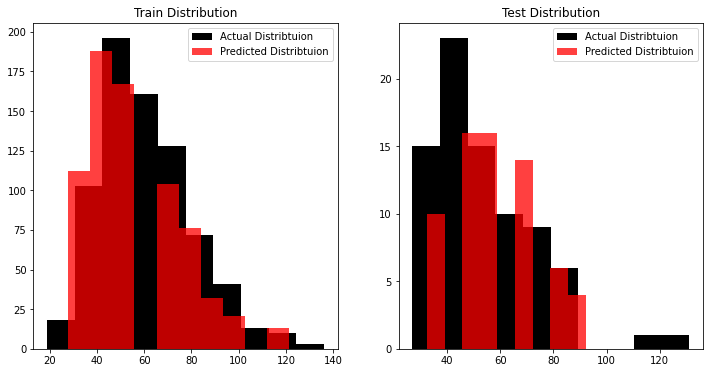

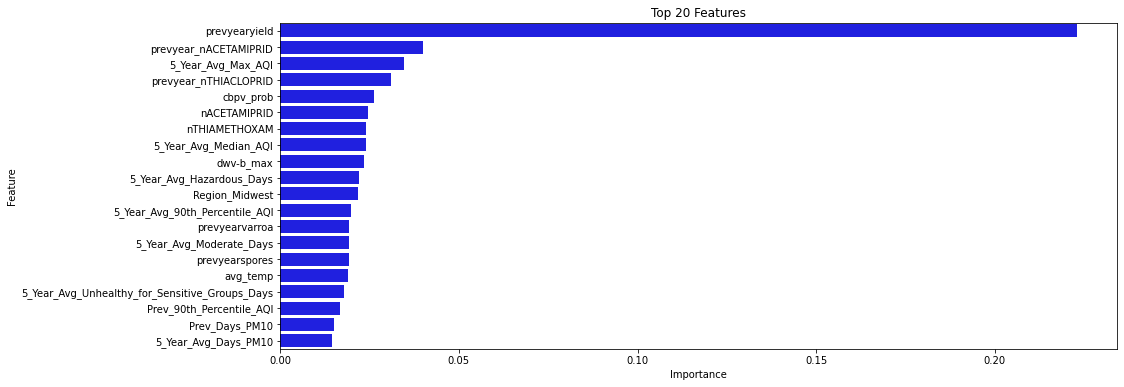

In [20]:
#no_states = [col for col in df_dropped_cols.columns if ]
df_no_states = df_dropped_cols[[col for col in df_dropped_cols.columns if 'StateName' not in col]]
train = df_no_states[df_no_states['year'] < 2016]
test = df_no_states[df_no_states['year'] >= 2016]
train.drop(columns='year', inplace=True)
test.drop(columns='year', inplace=True)
X_train = train.drop(columns='yieldpercol')
y_train = train['yieldpercol']
X_test = test.drop(columns='yieldpercol')
y_test = test['yieldpercol']
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=20, figsize=(15, 6))

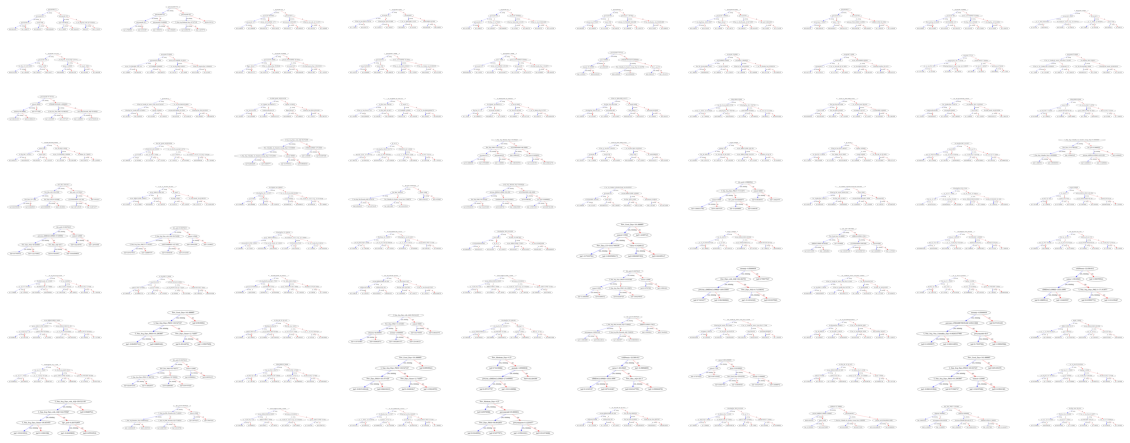

In [21]:
plot_forest(model, X_train, is_xgb=True, n_rows=10, n_cols=10, figsize=(20, 8), savefig=True, dpi=300)